# Annual Streamflow volume Processing and Visualization

This notebook processes streamflow simulated output from the MESH model climate change simulation, which includes 15 realizations. The data is used to visualize annual volume changes over three distinct periods (1980-2010, 2025-2055, 2070-2100) for selected stations. The data is read from CSV files, processed to handle missing values, and aggregated annually. The results are plotted as box plots showing the distribution of annual volumes, with percentage changes annotated.

## Steps

### 1. Import Libraries
Libraries for data manipulation (`pandas`, `numpy`), plotting (`matplotlib`), file handling (`glob`), and sorting (`natsort`) are imported.

### 2. User-defined Inputs
Define paths for input data and output figures.
Set start and end dates for the three periods.
Specify station identifiers and names.
Set colors for box plots and other plot attributes.

### 3. Read and Process CSV Files
Collect all relevant CSV files using `glob` with a wildcard pattern (`outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv`) to match all realization simulations from the MESH model. This ensures that data from 15 climate change simulation runs is included.
Sort the files naturally using `natsort`.
Read the CSV files into DataFrames, replacing missing values (`-1`) with `NaN` and dropping columns with all `NaN` values.
Concatenate the DataFrames into a single DataFrame with a MultiIndex.

### 4. Date and Year Extraction
Extract dates from `YEAR` and `JDAY` columns and add them to the DataFrame.
Group the data by year and sum it for the defined periods.

### 5. Data Aggregation
Adjust column names for consistency.
Stack data for each station and period, concatenate results, and ensure columns are in natural order.
Convert values to billion cubic meters.

### 6. Plotting
Configure plot aesthetics.
Create subplots for each station and plot the box plots for the three periods.
Customize box plot colors and add grid lines.
Calculate and annotate percentage changes in median annual volume for future periods relative to the historical period.

### 7. Final Plot
Add a y-axis label and title, display the plot, and save it to the specified path.

If you have any comments, please reach out to Fuad Yassin at fuad.yassin@usask.ca.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from natsort import natsorted

In [7]:
#  inputs
input_path = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
output_path = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt/xFigures'
start_dates = ['1980-01-01', '2025-01-01', '2070-01-01']
end_dates = ['2010-12-31', '2055-12-31', '2100-12-31']
station_list = ['QOSIM6', 'QOSIM20', 'QOSIM27', 'QOSIM33', 'QOSIM46', 'QOSIM48']
station_names = ['Oldman', 'Bow', 'Red Deer', 'N.SK Edmonton', 'N.SK Prince Albert', 'S.SK Saskatoon']
colors = ['#5B5B5B', 'orange', '#0066CC']
plot_title = 'Annual Volume (Million dam³)'
save_as = 'boxSel_noglc_nomgnt_flow_python5.png'

In [8]:
# Get list of CSV files
csv_files = glob.glob(f"{input_path}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files = natsorted(csv_files)

# Read CSV files into a list of DataFrames
data_frames = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files]

# Concatenate DataFrames
concatenated_df = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames)}, axis=1)

# Remove spaces from MultiIndex column names
concatenated_df.columns = concatenated_df.columns.map(lambda x: (x[0].strip(), x[1].strip()))

# Extract date from YEAR and JDAY columns
concatenated_df[('date', 'date')] = pd.to_datetime(concatenated_df[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df[('R1', 'JDAY')] - 1, unit='d')
concatenated_df[('year', 'year')] = concatenated_df[('date', 'date')].dt.year


In [9]:

# Group by year and sum for specified periods
df_1980_2010 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates[0]) & (concatenated_df[('date', 'date')] <= end_dates[0])].groupby(('year', 'year')).sum()
df_2025_2055 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates[1]) & (concatenated_df[('date', 'date')] <= end_dates[1])].groupby(('year', 'year')).sum()
df_2070_2100 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates[2]) & (concatenated_df[('date', 'date')] <= end_dates[2])].groupby(('year', 'year')).sum()

# Update column names for consistency
for df in [df_1980_2010, df_2025_2055, df_2070_2100]:
    df.columns.names = ['REALIZATION', 'Station']

# Concatenate data along the second level of the MultiIndex
df_1980_2010_apnd = pd.concat([df_1980_2010.xs(col, level=1, axis=1).stack(dropna=False) for col in df_1980_2010.columns.levels[1][1:-3]], axis=1)
df_2025_2055_apnd = pd.concat([df_2025_2055.xs(col, level=1, axis=1).stack(dropna=False) for col in df_2025_2055.columns.levels[1][1:-3]], axis=1)
df_2070_2100_apnd = pd.concat([df_2070_2100.xs(col, level=1, axis=1).stack(dropna=False) for col in df_2070_2100.columns.levels[1][1:-3]], axis=1)

# Update column names
column_names = df_1980_2010.columns.levels[1][1:-3]
df_1980_2010_apnd.columns = column_names
df_2025_2055_apnd.columns = column_names
df_2070_2100_apnd.columns = column_names

# Convert to billion cubic meters
conversion_factor = (24 * 60 * 60) / 1e9
df_1980_2010_apnd *= conversion_factor
df_2025_2055_apnd *= conversion_factor
df_2070_2100_apnd *= conversion_factor

# Reindex for consistent column order
df_1980_2010_apnd = df_1980_2010_apnd.reindex(natsorted(df_1980_2010_apnd.columns), axis=1)
df_2025_2055_apnd = df_2025_2055_apnd.reindex(natsorted(df_2025_2055_apnd.columns), axis=1)
df_2070_2100_apnd = df_2070_2100_apnd.reindex(natsorted(df_2070_2100_apnd.columns), axis=1)



In [11]:
data = [df_1980_2010_apnd[station_list[0]], df_2025_2055_apnd[station_list[0]], df_2070_2100_apnd[station_list[0]]]
data

[(year, year)  REALIZATION
 1980          R1             1.344361
               R2             1.202573
               R3             1.202573
               R4             2.056309
               R5             2.056309
                                ...   
 2010          R25            1.901126
               R26            2.381886
               R27            2.381886
               R28            3.030561
               R29            3.030561
 Name: QOSIM6, Length: 899, dtype: float64,
 (year, year)  REALIZATION
 2025          R1             1.863127
               R2             1.394938
               R3             1.394938
               R4             1.745606
               R5             1.745606
                                ...   
 2055          R25            2.080777
               R26            3.317278
               R27            3.317278
               R28            1.030208
               R29            1.030208
 Name: QOSIM6, Length: 899, dtype: float64,


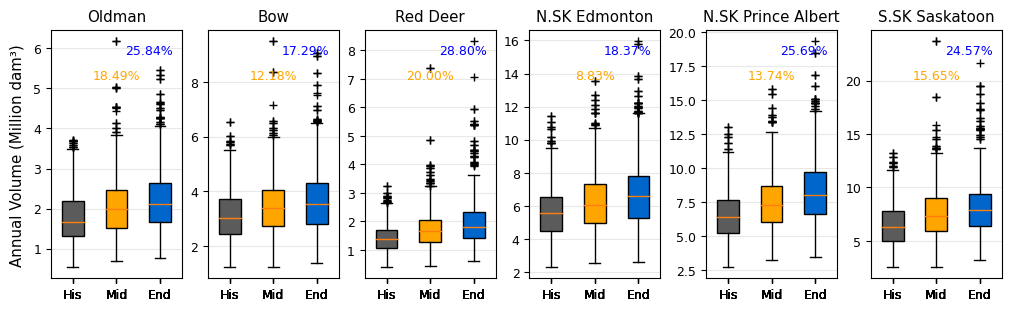

In [12]:
# Plotting
mpl.rcParams.update({'font.size': 9})

# Create subplots
fig, axes = plt.subplots(1, len(station_list), sharex=True, figsize=(10, 3), dpi=100, constrained_layout=True)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Extract data for each box plot
    data = [df_1980_2010_apnd[station_list[i]], df_2025_2055_apnd[station_list[i]], df_2070_2100_apnd[station_list[i]]]
    # Plot the box plots
    bplt = ax.boxplot(data, notch=0, sym='+', vert=1, whis=1.5, widths=(0.5, 0.5, 0.5), patch_artist=True, labels=['His', 'Mid', 'End'])
    # Customize box plot colors
    for patch, color in zip(bplt['boxes'], colors):
        patch.set_facecolor(color)
    # Add grid
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    # Set subplot title
    ax.set_title(station_names[i], color="k")
    # Calculate percentage change for the third series (2070-2100) relative to the first series (1980-2010)
    median_change_3rd = (df_2070_2100_apnd[station_list[i]].median() - df_1980_2010_apnd[station_list[i]].median()) / df_1980_2010_apnd[station_list[i]].median() * 100
    # Calculate percentage change for the second series (2025-2055) relative to the first series (1980-2010)
    median_change_2nd = (df_2025_2055_apnd[station_list[i]].median() - df_1980_2010_apnd[station_list[i]].median()) / df_1980_2010_apnd[station_list[i]].median() * 100
    # Add percentage change text to the second and third box plots
    ax.text(0.5, 0.8, f'{median_change_2nd:.2f}%', transform=ax.transAxes, ha='center', color='orange')
    ax.text(0.75, 0.9, f'{median_change_3rd:.2f}%', transform=ax.transAxes, ha='center', color='blue')

# Add y-axis label and plot title
fig.supylabel(plot_title)
# Show plot
plt.show()
# Save plot
fig.savefig(f"{output_path}/{save_as}")
